===== UCB vs ε-greedy Performance (Avg Reward) =====


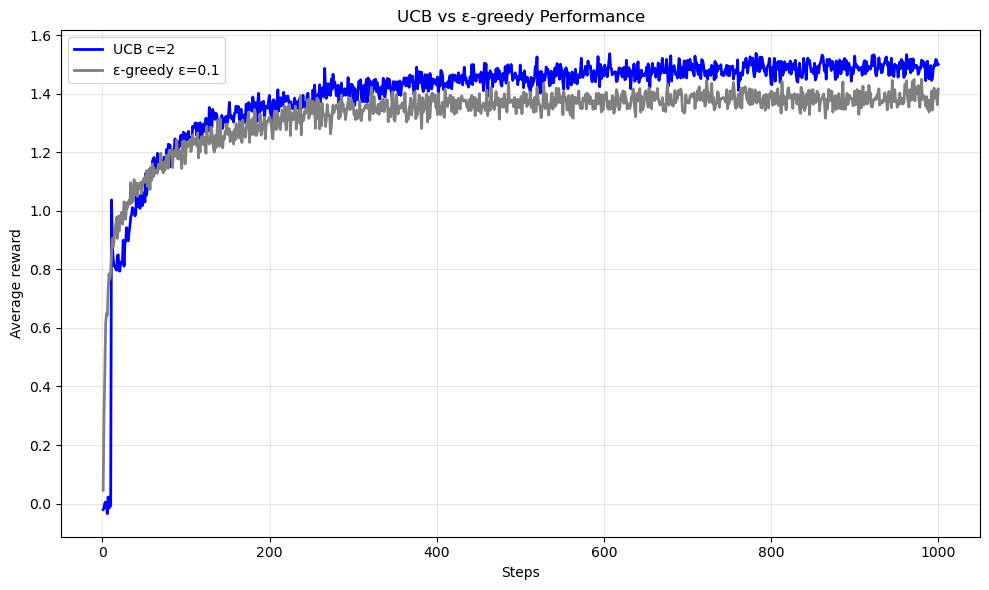

===== Optimistic vs Realistic Initialization (% Optimal) =====


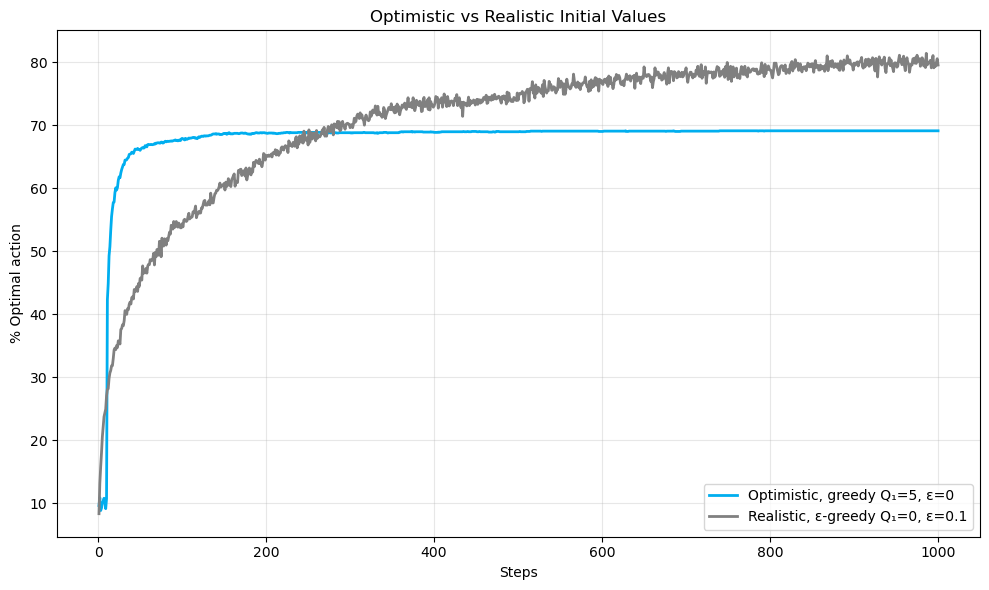

See notes in comments and function docstrings for RL logic.


In [7]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Multi-armed Bandit Experiments (CORRECTED VERSION)
# This code recreates the textbook figures comparing UCB vs epsilon-greedy
# and optimistic vs realistic epsilon-greedy strategies
# using numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt

def create_bandit_problem(num_arms, true_mean=0, true_std=1):
    """
    Create the testbed: assigns each arm a true mean drawn from a stationary normal distribution.
    The optimal arm is the slot machine with highest expected payout.
    """
    true_values = np.random.normal(true_mean, true_std, num_arms)
    optimal_arm = np.argmax(true_values)
    return true_values, optimal_arm

def get_reward(true_value, reward_std=1):
    """
    Simulates pulling an arm: returns a reward drawn from a normal dist centered on the arm's true value.
    Adds Gaussian noise to reflect real-world variability.
    """
    return np.random.normal(true_value, reward_std)

def epsilon_greedy_action(Q_values, epsilon):
    """
    Chooses an action using the epsilon-greedy policy:
    - With probability epsilon, explores (randomly chooses any arm).
    - Otherwise, exploits (chooses best estimated arm, breaking ties randomly).
    """
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q_values))
    else:
        max_value = np.max(Q_values)
        best_actions = np.where(Q_values == max_value)[0]
        return np.random.choice(best_actions)

def ucb_action(Q_values, action_counts, timestep, c=2):
    """
    Selects action via Upper Confidence Bound:
    At each timestep, picks arm with best combo of reward estimate and uncertainty bonus.
    Forces early exploration, then shifts to exploitation as more is learned.
    """
    untried = np.where(action_counts == 0)[0]
    if len(untried) > 0:
        return np.random.choice(untried)
    bonus = c * np.sqrt(np.log(timestep) / action_counts)
    ucb_values = Q_values + bonus
    return np.argmax(ucb_values)

def update_q_value(current_q, reward, count):
    """
    Incremental sample-average update (no memory of history needed):
    New Q = Old Q + [1/count] * (reward - Old Q)
    Each new sample nudges the estimate toward reality.
    """
    return current_q + (1.0 / count) * (reward - current_q)

def run_bandit_experiment(algorithm, num_arms, num_steps, initial_q=0, **kwargs):
    """
    Simulates a single run of a bandit agent:
    - Tracks reward and optimal arm selections per step.
    - Algorithm can be 'epsilon_greedy' or 'ucb'
    - initial_q param sets optimistic/realistic initialization.
    """
    true_values, optimal_arm = create_bandit_problem(num_arms)
    Q_values = np.full(num_arms, initial_q, dtype=float)
    action_counts = np.zeros(num_arms, dtype=int)
    rewards = np.zeros(num_steps)
    optimal_actions = np.zeros(num_steps, dtype=bool)
    for step in range(num_steps):
        if algorithm == 'epsilon_greedy':
            action = epsilon_greedy_action(Q_values, kwargs['epsilon'])
        elif algorithm == 'ucb':
            action = ucb_action(Q_values, action_counts, step + 1, kwargs.get('c', 2))
        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")
        reward = get_reward(true_values[action])
        rewards[step] = reward
        optimal_actions[step] = (action == optimal_arm)
        action_counts[action] += 1
        Q_values[action] = update_q_value(Q_values[action], reward, action_counts[action])
    return rewards, optimal_actions

def run_multiple_experiments(algorithm, num_runs, num_arms, num_steps, **kwargs):
    """
    Runs many independent problems and averages results:
    - Smooths out randomness to make textbook-style figures
    """
    all_rewards = np.zeros((num_runs, num_steps))
    all_optimal = np.zeros((num_runs, num_steps))
    for run in range(num_runs):
        rewards, optimal = run_bandit_experiment(algorithm, num_arms, num_steps, **kwargs)
        all_rewards[run] = rewards
        all_optimal[run] = optimal
    return all_rewards, all_optimal

def figure_ucb_vs_eps():
    """
    Reproduces textbook figure: average reward over time for UCB vs ε-Greedy
    UCB should perform better after initial exploration
    """
    num_runs, num_arms, num_steps = 2000, 10, 1000
    ucb_rewards, _ = run_multiple_experiments('ucb', num_runs, num_arms, num_steps, c=2)
    eg_rewards, _ = run_multiple_experiments('epsilon_greedy', num_runs, num_arms, num_steps, epsilon=0.1)
    plt.figure(figsize=(10,6))
    steps = np.arange(1, num_steps+1)
    plt.plot(steps, np.mean(ucb_rewards, axis=0), 'b-', label='UCB c=2', linewidth=2)
    plt.plot(steps, np.mean(eg_rewards, axis=0), color='gray', label='ε-greedy ε=0.1', linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.title('UCB vs ε-greedy Performance')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def figure_optimistic_vs_realistic():
    """
    Textbook: compares optimistic greedy (Q₁=5, ε=0) vs realistic ε-greedy (Q₁=0, ε=0.1).
    Shows that optimistic greedy explores early, then exploits, while realistic ε-greedy keeps exploring.
    Textbook curve: optimistic greedy plateaus higher.
    """
    num_runs = 2000
    num_arms = 10
    num_steps = 1000

    # Optimistic greedy: Q=5, epsilon=0.0 (pure greedy)
    opt_rewards, opt_optimal = run_multiple_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps,
        initial_q=5.0, epsilon=0.0
    )
    # Realistic epsilon-greedy: Q=0, epsilon=0.1
    real_rewards, real_optimal = run_multiple_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps,
        initial_q=0.0, epsilon=0.1
    )

    steps = np.arange(1, num_steps + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(steps, np.mean(opt_optimal, axis=0)*100, color='#00AEEF', label='Optimistic, greedy Q₁=5, ε=0', linewidth=2)
    plt.plot(steps, np.mean(real_optimal, axis=0)*100, color='gray', label='Realistic, ε-greedy Q₁=0, ε=0.1', linewidth=2)
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.title('Optimistic vs Realistic Initial Values')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def main():
    """
    Runs both textbook figures with detailed comments from your notes.
    """
    np.random.seed(123)  # for reproducibility
    print("===== UCB vs ε-greedy Performance (Avg Reward) =====")
    figure_ucb_vs_eps()
    print("===== Optimistic vs Realistic Initialization (% Optimal) =====")
    figure_optimistic_vs_realistic()
    print("See notes in comments and function docstrings for RL logic.")

if __name__ == "__main__":
    main()
